# BART

In this lab, we will cover BART. Bayesian Additive Regression Trees (BART) is a non-linear, non-parametric Bayesian statistical model. It's used for regression and classification problems and has been shown to provide flexible fits to complex datasets, often outperforming traditional methods like linear regression or classification and regression trees.

BART models data as a sum of decision trees where each tree is constrained by a prior to be a weak learner, contributing a small amount to the overall prediction. This setup helps in avoiding overfitting, which is a common problem with methods that use decision trees, such as random forests.

In more technical terms, given a response variable Y and predictor variables X1, X2, ..., Xp, BART assumes the following relationship:

Y = f(X1, X2, ..., Xp) + e

where f(X1, X2, ..., Xp) is an unknown function and e is a normally distributed error term. BART approximates the unknown function f by an additive model of binary trees.

The "Bayesian" part of BART comes in because it uses Bayesian methods to learn from the data and make predictions. 

In [1]:
# Uncomment & install if pymc and pymc_bart is not already installed in your computer
#!pip3 install pymc
#!pip3 install pymc_bart

In [2]:
import numpy as np
import pandas as pd
import pymc as pm

In [3]:
import arviz as az #ArviZ is a Python package for exploratory analysis of Bayesian models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm #PyMC (formerly PyMC3) is a Python package for Bayesian statistical modeling
import pymc_bart as pmb # PyMC-BART extends PyMC 

from sklearn.model_selection import train_test_split

print(f"Running on PyMC v{pm.__version__}") #bart might not work in older version of pymc

Running on PyMC v5.6.1


In [4]:
RANDOM_SEED = 300
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In this lab, we will first use coal mining disaster dataset. This is a popular dataset in the PYMC library documentation. We will discretize the dataset by building a histogram and use center of bins as x variable and counts per bin as y variable. 

In [5]:
# The file "coal.csv" would be included in the PyMC library installation on your computer
# As per the numpy.loadtxt() function, it expects the file to be a text file with numerical
# data, and it will load this data into a NumPy array called coal. csv file is a type of text file.
coal = np.loadtxt(pm.get_data("coal.csv"))

In [6]:
# discretize data
years = int(coal.max() - coal.min()) # calculates the range of the data. If the coal 
# dataset represents years, this would give the number of years the data spans.
bins = years // 4 # '//' calculates the number of bins for the histogram by 
# performing floor division. The // operator divides and rounds down to the nearest whole 
# number. 
hist, x_edges = np.histogram(coal, bins=bins) # hist will be an array with the number of
# elements in each bin, and x_edges will be an array with the edge values of the bins.
# compute the location of the centers of the discretized data

x_centers = x_edges[:-1] + (x_edges[1] - x_edges[0]) / 2 #  calculates the centers of the
# bins. It does this by adding half the bin width ((x_edges[1] - x_edges[0]) / 2) 
# to the left edges of the bins (x_edges[:-1]). This is done to represent each bin by
#its center point rather than its edges.

x_data = x_centers[:, None] # converts x_centers into a 2D array with one column. 
# The None indexing is used to add an extra dimension. This is done because the BART  
# model expects 2D input.

# just renames hist to y_data. This data represents the counts in each bin 
# (or the number of disasters per year).
y_data = hist

In [7]:
with pm.Model() as model_coal: # This line is creating a new probabilistic model using PyMC3. Everything that happens within the with block pertains to this model_coal.
    μ_ = pmb.BART("μ_", X=x_data, Y=np.log(y_data), m=20) # This line is defining a BART model with the predictor variable X set to x_data and the response variable Y set to np.log(y_data). The m=20 parameter is defining the number of trees to use in the BART model. The output of this model is being stored in μ_

    
    μ = pm.Deterministic("μ", pm.math.exp(μ_)) # This line is defining a deterministic variable μ, which is the exponential of μ_. This is done because μ_ is on the log scale due to the np.log(y_data) used in the BART model.
    y_pred = pm.Poisson("y_pred", mu=μ, observed=y_data)
    idata_coal = pm.sample(random_seed=RANDOM_SEED)# sample from the posterior distribution of the model

Multiprocess sampling (4 chains in 4 jobs)
PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


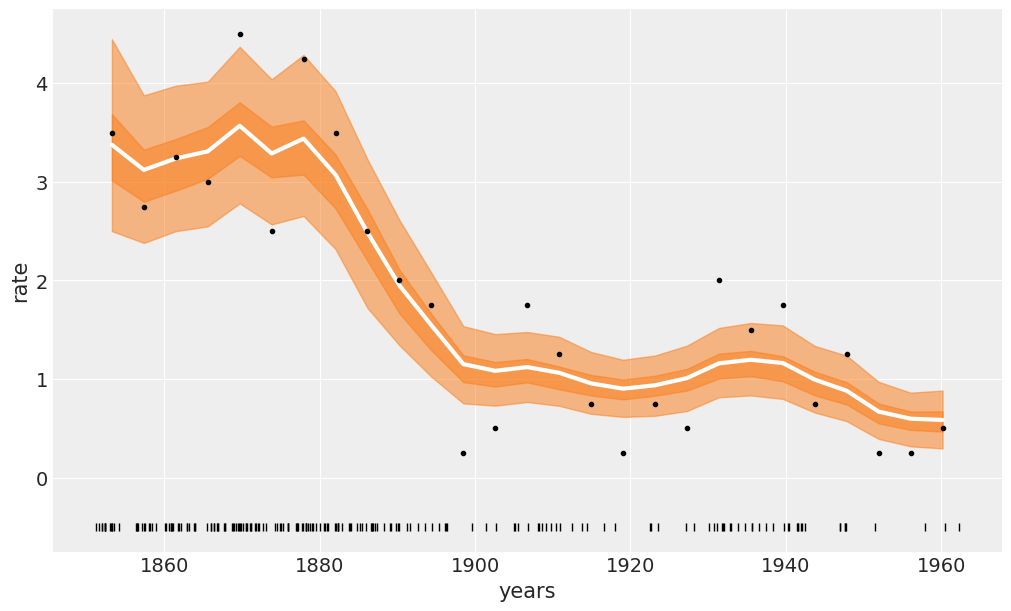

In [8]:
_, ax = plt.subplots(figsize=(10, 6)) # The underscore (_) is a common convention in Python for a variable name that we don't plan to use.

rates = idata_coal.posterior["μ"] / 4
rate_mean = rates.mean(dim=["draw", "chain"])
ax.plot(x_centers, rate_mean, "w", lw=3)
ax.plot(x_centers, y_data / 4, "k.")
az.plot_hdi(x_centers, rates, smooth=False)
az.plot_hdi(x_centers, rates, hdi_prob=0.5, smooth=False, plot_kwargs={"alpha": 0})
ax.plot(coal, np.zeros_like(coal) - 0.5, "k|")
ax.set_xlabel("years")
ax.set_ylabel("rate");

The white line in the plot above shows the median rate of accidents. The darker orange band represent the HDI 50% and the lighter one the 94%. We can see a rapid decrease of coal accidents between 1880 and 1900. 


The following figure shows two samples of μ
from the posterior.

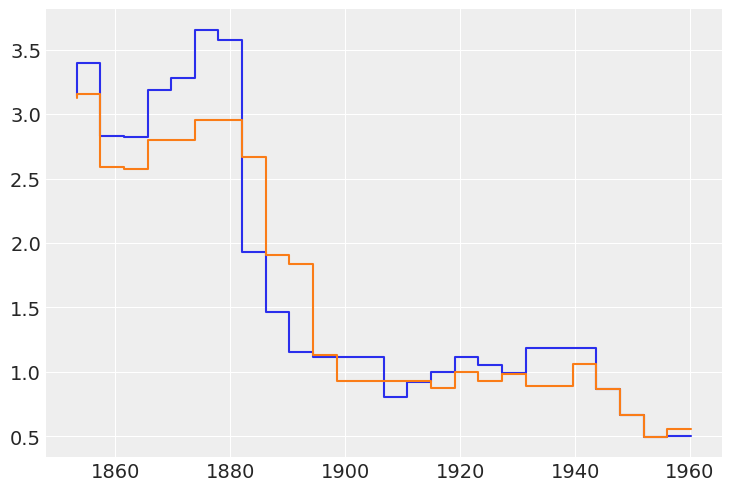

In [9]:
plt.step(x_data, rates.sel(chain=0, draw=[3, 10]).T);

Now let's explore BART using four covariate using a subset of popular bike sharing dataset.
We will use the following variables: number of bike rental in a city, the hour of the day, the temperature, the humidity, and whether it is a weekday or weekend. 


In [10]:
bikes = pd.read_csv(pm.get_data("bikes.csv"))  # the file bikes.csv is included in pymc installation
bikes.head()

,count,hour,temperature,humidity,workingday
0,16,0,0.24,0.81,0
1,28,0,0.70,0.79,1
2,128,0,0.60,0.88,0
3,29,0,0.62,0.78,1
4,52,0,0.62,0.94,1


In [11]:
features = ["hour", "temperature", "humidity", "workingday"]



In [12]:
X = bikes[features]
Y = bikes["count"]

In [ ]:
with pm.Model() as model_bikes:
    α = pm.Exponential("α", 1)
    μ = pmb.BART("μ", X, np.log(Y), m=50)
    y = pm.NegativeBinomial("y", mu=pm.math.exp(μ), alpha=α, observed=Y)
    idata_bikes = pm.sample(compute_convergence_checks=False, random_seed=RANDOM_SEED)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ]


# Partial dependence plots

To aid in the interpretation of our model's results, we will employ partial dependence plots. These plots demonstrate the marginal effect of one covariate on the predicted variable. PyMC-BART provides an utility function to make this plot from the inference data.


In [ ]:
pmb.plot_pdp(μ, X=X, Y=Y, grid=(2, 2), func=np.exp) # explore plot_pdp function futher at https://github.com/pymc-devs/pymc-bart/blob/main/pymc_bart/utils.py

From the plot above, we can see the main effect of each covariate on the predicted value. For example for the hour covariate we can see two peaks around 8 and and 17 hs and a minimum at 12.

### Acknowledgement
The lab was adapted from the following official documentation in PyMC. https://www.pymc.io/projects/examples/en/latest/case_studies/BART_introduction.html Please explore the official documentation if you want to learn more. 